In [1]:
import yfinance as yp
import pandas as pd
import numpy as np


In [71]:
adani=yp.Ticker("ADANIPOWER.NS")

In [73]:
data= adani.history(period="max")

In [74]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-08-20,108.000000,110.000000,98.300003,100.099998,164328256,0,0
2009-08-21,99.900002,103.900002,98.000000,103.150002,33717840,0,0
2009-08-24,103.900002,104.400002,101.550003,103.099998,13665282,0,0
2009-08-25,102.500000,103.150002,101.000000,102.750000,11720267,0,0
2009-08-26,103.000000,107.500000,102.849998,105.099998,17158838,0,0
...,...,...,...,...,...,...,...
2022-09-13,400.500000,400.500000,392.500000,393.600006,2257842,0,0
2022-09-14,385.750000,397.000000,383.299988,384.549988,3469526,0,0
2022-09-15,389.500000,399.950012,383.000000,399.200012,2988397,0,0


In [75]:
data.index = pd.to_datetime(data.index)


In [76]:
import plotly.graph_objs as go

<AxesSubplot:xlabel='Date'>

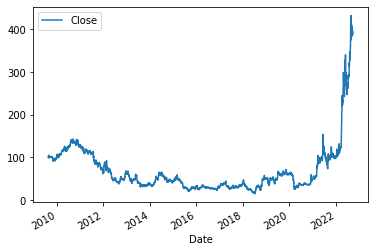

In [77]:
data.plot.line(y="Close", use_index=True)

In [78]:
del data["Dividends"]
del data["Stock Splits"]

In [79]:
data["Tomorrow"] = data["Close"].shift(-1)

In [80]:
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

In [81]:
data.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2009-08-20,108.000000,110.000000,98.300003,100.099998,164328256,103.150002,1
2009-08-21,99.900002,103.900002,98.000000,103.150002,33717840,103.099998,0
2009-08-24,103.900002,104.400002,101.550003,103.099998,13665282,102.750000,0
2009-08-25,102.500000,103.150002,101.000000,102.750000,11720267,105.099998,1
2009-08-26,103.000000,107.500000,102.849998,105.099998,17158838,104.750000,0


In [82]:
data["Target"].value_counts()

0    1678
1    1549
Name: Target, dtype: int64

# Random forest model

### Simple random forest

In [83]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-200]
test = data.iloc[-200:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [84]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5862068965517241

<AxesSubplot:xlabel='Date'>

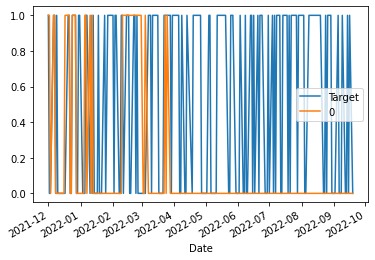

In [85]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

# Creating a back testing function

In [86]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined


In [157]:
def backtest(data, model, predictors, start=900, step=300):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [158]:
predictions = backtest(data, model, predictors)

In [159]:
predictions

,Target,Predictions
Date,,
2013-04-11,1,0
2013-04-12,0,0
2013-04-15,1,1
2013-04-16,0,0
2013-04-17,1,0
...,...,...
2022-09-13,0,0
2022-09-14,1,0
2022-09-15,0,0


In [160]:
predictions["Predictions"].value_counts()

0    1403
1     924
Name: Predictions, dtype: int64

In [161]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4816017316017316

**The accuracy of the model is not good enough to be used for production, so lets make some chnages in the dataset and model and see if can improve the accuracy** 

In [162]:
horizons = [2,5,60,250]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [163]:
new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250']

In [164]:
print(data.head())
print(data.shape)


                  Open        High         Low       Close     Volume  \
Date                                                                    
2009-08-20  108.000000  110.000000   98.300003  100.099998  164328256   
2009-08-21   99.900002  103.900002   98.000000  103.150002   33717840   
2009-08-24  103.900002  104.400002  101.550003  103.099998   13665282   
2009-08-25  102.500000  103.150002  101.000000  102.750000   11720267   
2009-08-26  103.000000  107.500000  102.849998  105.099998   17158838   

              Tomorrow  Target  Close_Ratio_2  Trend_2  Close_Ratio_5  \
Date                                                                    
2009-08-20  103.150002       1            NaN      NaN            NaN   
2009-08-21  103.099998       0       1.015006      NaN            NaN   
2009-08-24  102.750000       0       0.999758      1.0            NaN   
2009-08-25  105.099998       1       0.998300      0.0            NaN   
2009-08-26  104.750000       0       1.011306     

In [165]:
#Dropping all the rows with nan values
data = data.dropna(subset=data.columns[data.columns != "Tomorrow"])

In [166]:
data

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,
2010-08-25,140.300003,140.699997,136.000000,137.149994,1311215,137.050003,0,0.992223,0.0,0.984778,2.0,1.070300,30.0,1.234747,128.0
2010-08-26,138.350006,139.250000,136.500000,137.050003,1493848,135.500000,0,0.999635,0.0,0.988389,1.0,1.067098,29.0,1.232342,127.0
2010-08-27,137.100006,138.550003,134.800003,135.500000,1366306,136.050003,1,0.994313,0.0,0.983381,1.0,1.052693,29.0,1.216986,127.0
2010-08-30,137.399994,137.600006,134.699997,136.050003,1130702,135.949997,0,1.002025,1.0,0.992993,1.0,1.054351,30.0,1.220466,128.0
2010-08-31,136.000000,136.699997,133.899994,135.949997,694884,138.199997,1,0.999632,1.0,0.997139,1.0,1.050808,30.0,1.218221,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-13,400.500000,400.500000,392.500000,393.600006,2257842,384.549988,0,0.994944,1.0,0.985774,1.0,1.203253,35.0,2.005462,131.0
2022-09-14,385.750000,397.000000,383.299988,384.549988,3469526,399.200012,1,0.988370,0.0,0.973717,1.0,1.168250,34.0,1.948075,131.0
2022-09-15,389.500000,399.950012,383.000000,399.200012,2988397,387.750000,0,1.018692,1.0,1.012196,2.0,1.203558,35.0,2.010071,132.0


In [167]:

model_2 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [168]:
predictions_2 = backtest(data, model_2, new_predictors)

In [169]:
precision_score(predictions_2["Target"], predictions_2["Predictions"])

0.5138339920948617

In [170]:
predictions_2["Predictions"].value_counts()

0    1318
1     759
Name: Predictions, dtype: int64

In [171]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.515256
1    0.484744
Name: Target, dtype: float64

In [172]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

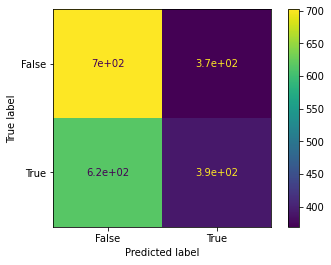

In [173]:
import matplotlib.pyplot as plt
conf_matrix=confusion_matrix(predictions_2["Target"], predictions_2["Predictions"])
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [174]:
conf_matrix

array([[702, 369],
       [616, 390]], dtype=int64)

Here we are actually labelling False as True (0 as 1) which is reducing the accuracy of our model. Changing our labelling stratergy might help to improve the accuracy

**It can be seen that the accuracy of the model has increased, Hence this model is better**

In [175]:
#new predict function for higher accuracy
def predict_prob(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

The above predict function will help us to avoid labeling a false as True

In [180]:
def backtest_prob(data, model, predictors, start=900, step=300):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_prob(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [181]:
predictions_3=backtest_prob(data, model_2, new_predictors)

In [182]:
precision_score(predictions_3["Target"], predictions_3["Predictions"])

0.5677083333333334

In [183]:
confusion_matrix(predictions_3["Target"], predictions_3["Predictions"])

array([[988,  83],
       [897, 109]], dtype=int64)

After changing the labeling straterg, it can be seen that there is increase in the accuracy of our model, let use a more powerful model and see if can make things better

In [194]:
from xgboost import XGBClassifier

model_3 = XGBClassifier(random_state=1, learning_rate=.01, n_estimators=200)
predictions_4 = backtest_prob(data, model_3,new_predictors)

In [195]:
precision_score(predictions_4["Target"], predictions_4["Predictions"])

0.5283842794759825

In [196]:
confusion_matrix(predictions_4["Target"], predictions_4["Predictions"])

array([[963, 108],
       [885, 121]], dtype=int64)

Our model 2 has given us the best results. Using this model with other fundamental factors might be profitable

In [197]:
from joblib import Parallel, delayed
import joblib

# Save the model as a pickle in a file
joblib.dump(model_2, 'adani.pkl')

['adani.pkl']